In [ ]:
import numpy as np
import torch
from transformers import VideoMAEForPreTraining, VideoMAEImageProcessor

# 1. 加载预训练的 VideoMAE 模型和图像处理器
model_name = "MCG-NJU/videomae-base"
model = VideoMAEForPreTraining.from_pretrained(model_name)
processor = VideoMAEImageProcessor.from_pretrained(model_name)

# 2. 准备数据和掩码
num_frames = 16
channels = 3
height = 224
width = 224

# 创建示例数据和掩码
data = np.random.randn(num_frames, channels, height, width).astype(np.float32) #* 16,3,224,224

# 强制数据在 [0, 1] 范围内
data = np.clip(data, 0, 1)

# 确保数据通道顺序为 [frames, height, width, channels]
data = data.transpose(0, 2, 3, 1)#* 16,224,224,3

# 将数据和掩码转换为 PyTorch 的 Tensor
pixel_values = processor(images=list(data), return_tensors="pt", do_rescale=False).pixel_values
#* 16,[3,224,224]
# 计算掩码的形状和序列长度
num_patches_per_frame = (model.config.image_size // model.config.patch_size) ** 2 #* (224//16)**2=196
tubelet_seq_length = num_frames//model.config.tubelet_size#! tubelet_size:The number of tubelets

# 随机生成掩码（0表示缺失区域）
bool_masked_pos = torch.randint(0, 2, (1,num_patches_per_frame*tubelet_seq_length)).bool()# generate a array which shape is (1,seq_lem) and its range between (0,1)

# 3. 使用模型进行推理，得到编码后的特征表示
model.eval()
with torch.no_grad():
    outputs = model(pixel_values, bool_masked_pos=bool_masked_pos) # Patches are flattened and embedded into vectors.
    #! model pre-processing pixel_values [1, 16, 3, 224, 224] to [1,1568,768] ==[1,1568,16*16*3]==[batch_size,tubelet_size,patch_size]
    encoded_features = outputs.logits #* batch_size,embedded_seq_length,hidden_size -> 1,variant,1536
    #! the embedded_seq_length would change depending on how many patches were masked.
#! Spatiotemporal Consistency: The model does not shuffle or lose the order of patches during processing, 
#! so any reconstruction attempt (e.g., decoding or projecting back to the pixel space) 
#! should preserve the original spatial and temporal relationships between patches.
# 4. 调整输入形状，确保其形状为 [batch_size, seq_length, feature_dim]
# encoded_features = encoded_features.view(1, -1, model.config.hidden_size) # model.config.hidden_size=768
projection_layer = torch.nn.Linear(outputs.logits.shape[2], 384)# hidden_size decoder typically epected is 384
#! Linear Layer allows for learning and adjusting weights to best fit the data.
# 5. 使用 decoder 进行解码
#! the model's decoding process handles the reconstruction.
decoded_frames = model.decoder(projection_layer(outputs.logits), return_token_num=tubelet_seq_length*num_patches_per_frame)
#* 1, 712, 1536
linear_layer = torch.nn.Linear(1536, 3 * 14 * 14)  # Project to patch size
projected_patches = linear_layer(decoded_frames.logits)  # Shape: (1, 748, 768)
projected_patches = projected_patches.view(1,-1, 3, 14, 14)  # Shape: (1, 773, 3, 16, 16)
num_frames_reconstructed = projected_patches.shape[1] // tubelet_seq_length
reconstructed_video = torch.zeros(1, num_frames_reconstructed, 3, 224, 224)


In [1]:
import numpy as np
import os
import glob
import netCDF4 as nc
from torch.utils.data import DataLoader, Dataset
import torch
def load_data_from_directory(directory, scale_factor=1.0):
    file_paths = glob.glob(f'{directory}/*.nc')
    all_data = []
    all_masks = []
    
    for file_path in file_paths:
        dataset = nc.Dataset(file_path, 'r')
        file_name = os.path.basename(file_path)
        prefix = file_name.split('.')[0]
        data_var = dataset.variables[prefix][:]  # Adjust if needed
        data_var = np.expand_dims(data_var, axis=1)
        mask_var = dataset.variables['mask'][:]
        mask_var = np.expand_dims(mask_var, axis=0)
        missing_value = dataset.variables[prefix]._FillValue

        # Handle missing values
        mask = (mask_var == 1).astype(np.float32)
        data_var[data_var == missing_value] = 0
        data_var = np.nan_to_num(data_var, nan=0.0)

        # Apply scaling factor to the data
        data_var *= scale_factor
        all_data.append(data_var)
        all_masks.append(mask)

        dataset.close()

    # Combine all bands with a new channel dimension

    all_data = np.concatenate(all_data, axis=1)  # Merge all bands into channel dimension
    all_masks = np.concatenate(all_masks, axis=0)
    # Reshape data to fit [batch, time, channels, height, width]
    # all_data = np.expand_dims(all_data, axis=0) # [samples, time, channels, height, width]
    # all_masks = np.expand_dims(all_masks, axis=0) # [samples, channels, height, width]

    return all_data, all_masks
class OceanDataset(Dataset):
    len_frame=1
    def __init__(self, data,mask, use_random_mask=False, mask_ratio=0.0):
        self.data = data # [time, channels, height, width]
        self.mask = mask # [time, channels, height, width]
        self.use_random_mask = use_random_mask
        self.mask_ratio = mask_ratio

    def __len__(self,len_frame=len_frame):
        return int(self.data.shape[0]/len_frame)  # Number of sample

    def __getitem__(self, idx,len_frame=len_frame): #? The size and range of idx depend on the __len__
        data_sample = self.data[idx*len_frame:(idx+1)*len_frame, :, :]  # Take the first 4 time frames [channels, time, height, width]
        mask_sample = self.mask[0, :, :]  # Corresponding mask frames

        # Convert to torch tensor
        data_sample = torch.tensor(data_sample, dtype=torch.float32)
        mask_sample = torch.tensor(mask_sample, dtype=torch.float32)

        # Generate mask based on data_sample
        if self.use_random_mask:
            random_mask = torch.rand_like(mask_sample) < self.mask_ratio
            mask_sample = torch.max(mask_sample, random_mask.float())

        meta_data = (data_sample == 0).float()
        return data_sample, mask_sample, meta_data
    
# Load the data_var,mask #* (24,9,49,46) (9,49,46)
data_var, mask = load_data_from_directory('G:/YuJinYuan-Experiment/MODIS')
# Create dataset and Dataloader
dataset = OceanDataset(data_var,mask ,use_random_mask=False, mask_ratio=0.1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False) #? batch_size=1:it does automatically add an extra dimension 

torch.Size([4, 50, 50])


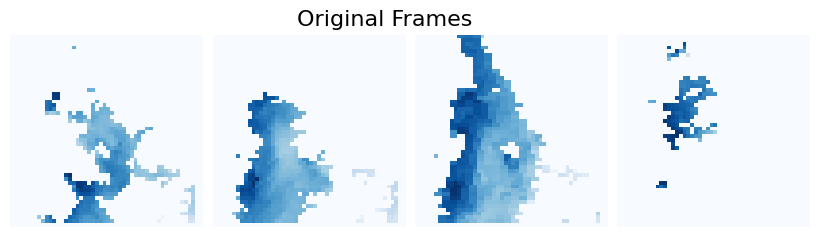

torch.Size([4, 50, 50])


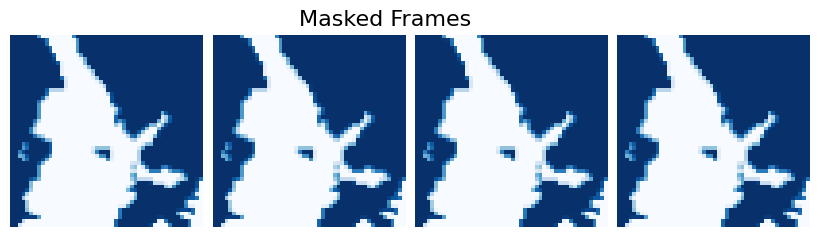

torch.Size([4, 50, 50])


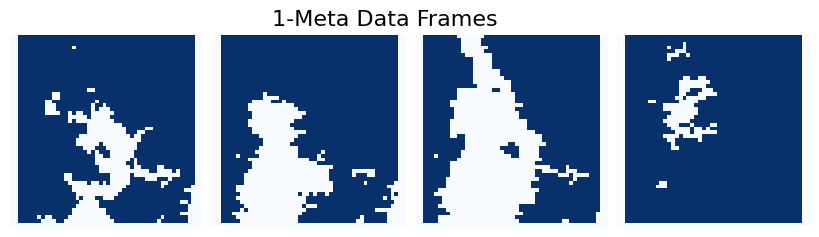

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
import torch.nn.functional as F

def show_sequence(seq, sample=1, title=''):
    # seq should be [num_frames, height, width, num_channels]
    print(seq.shape)
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    
    for ax, img in zip(grid, seq):
        img = img.squeeze()  # Remove the channel dimension for grayscale images
        ax.imshow((img * 10000), cmap='Blues')
        ax.set_axis_off()
    
    plt.show()
    return
def resize_tensor(tensor, target_size,mode,align_corners):
    # tensor shape: (batch_size, frames, channels, height, width)
    # target_size: tuple of (new_height, new_width)
    
    _, _, _, current_height, current_width = tensor.shape
    target_height, target_width = target_size
    
    # Calculate padding
    pad_height = max(0, target_height - current_height)
    pad_width = max(0, target_width - current_width)
    
    # Calculate padding for each side
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    # Pad the tensor
    padded_tensor = F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom))
    
    return padded_tensor
num_frames_to_show = 24
now_frame=0
orig_frames = []
masked_frames = []
meta_data_frames = []

for data_sample, mask_sample, meta_data in dataloader:
    # print(data_sample.shape, mask_sample.shape, meta_data.shape)  # Should output torch.Size([1, 4, 10, 49, 46])
    data_sample=resize_tensor(data_sample, (50, 50),'bilinear', False)
    mask_sample=mask_sample.view(-1,mask_sample.shape[-3],mask_sample.shape[-2],mask_sample.shape[-1])
    mask_sample=F.interpolate(mask_sample, size=(50, 50), mode='bilinear', align_corners=False)
    mask_sample=mask_sample.view(mask_sample.shape[-3],mask_sample.shape[-2],mask_sample.shape[-1])
    meta_data=resize_tensor(meta_data, (50, 50),'bilinear', False)

    # Collect frames within the valid range
    if now_frame < num_frames_to_show:
        orig_frames.append(data_sample[:, :, :, :, :].detach())
        masked_frames.append(mask_sample[:, :].detach())
        meta_data_frames.append(meta_data[:, :, :, :, :].detach())
        now_frame=now_frame+1
    else:
        break

# Convert lists to tensors
orig_frames = torch.cat(orig_frames, dim=1)
masked_frames = torch.cat(masked_frames, dim=0)
meta_data_frames = torch.cat(meta_data_frames, dim=1)

# Visualize frames
show_sequence(orig_frames[0,:4,0,:,:], sample=4, title='Original Frames')
show_sequence(1-masked_frames[:4,:,:], sample=4, title='Masked Frames')
show_sequence(meta_data_frames[0,:4,0,:,:], sample=4, title='1-Meta Data Frames')


In [3]:
import torch
import av
import numpy as np
from transformers import AutoImageProcessor, VideoMAEForPreTraining, VideoMAEConfig
from huggingface_hub import hf_hub_download
import torchvision.transforms as transforms
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the VideoMAE model for pre-training
config = VideoMAEConfig(
    image_size=50,
    patch_size=2,
    num_channels=1,
    num_frames=24,
    tubelet_size=1,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    qkv_bias=True,
    use_mean_pooling=True
)
# Function to read and sample video frames (provided)
def read_video_pyav(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    # return np.stack([x.to_ndarray(format="rgb24") for x in frames])
    return np.stack([x.to_ndarray(format="gray") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

# Download and extract frames from the video
file_path = hf_hub_download(repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset")
container = av.open(file_path)
# Sample 24(num_frames) frames (matching the original input tensor shape)
indices = sample_frame_indices(clip_len=config.num_frames, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video_frames = read_video_pyav(container, indices)

def read_video(frames, frame_size):
    # Define the transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(frame_size),
        transforms.Grayscale(num_output_channels=config.num_channels),#TODO when channels is one
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        transforms.Normalize(mean=[0.485], std=[0.229])#TODO when channels is one
    ])

    # Convert each frame (which is a NumPy array) to a PIL Image and apply the transformations
    processed_frames = torch.stack([transform(Image.fromarray(frame)) for frame in frames])
    
    return processed_frames

processed_input = read_video(video_frames, (config.image_size, config.image_size))
#TODO replace OceanDataset
input_tensor = orig_frames[:,:,:1,:,:].to(device)#*b (t p0) c (h p1) (w p2) 

# input_tensor = processed_input.unsqueeze(0).to(device)#* Tensor (1,16,3,112,112)
#TODO set first frame all white
# input_tensor[0, 0, :, :, :] = 1.0

#!only receive image_size of (224,224)
# # Initialize the image processor from the pretrained model 
# image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
# # Process the video frames into a tensor
# processed_input = image_processor(images=list(video_frames), return_tensors="pt")
# input_tensor = processed_input.pixel_values


model = VideoMAEForPreTraining(config).to(device)

# Create a mask for missing values
num_patches_per_frame = (config.image_size // config.patch_size) ** 2
#! seq_length:patch number of a tubelet
seq_length = (config.num_frames // config.tubelet_size) * num_patches_per_frame

bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool().to(device)#* Tensor (1,seq_length)
#! one tubelet only use one masking strategy
#TODO bool_masked_pos = torch.rand((1, config.num_frames // config.tubelet_size, config.image_size // config.patch_size, config.image_size // config.patch_size)) < 0.3
#TODO bool_masked_pos = bool_masked_pos.view(1, -1).bool()


# Forward pass through the model using the preprocessed video frames
outputs = model(pixel_values=input_tensor, bool_masked_pos=bool_masked_pos)

# The output contains the loss and reconstructed patches
loss = outputs.loss
reconstructed_patches = outputs.logits

# Display the loss and shape of the reconstructed patches
print("Loss:", loss.item())
print("Reconstructed patches shape:", reconstructed_patches.shape)


c:\Users\1\.conda\envs\ViT\Lib\site-packages\transformers\models\videomae\modeling_videomae.py:286: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Loss: 0.3497610092163086
Reconstructed patches shape: torch.Size([1, 7447, 4])


(1, 24, 50, 50, 1)


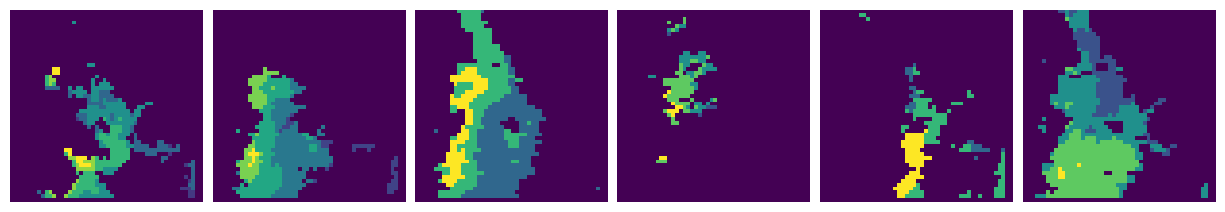

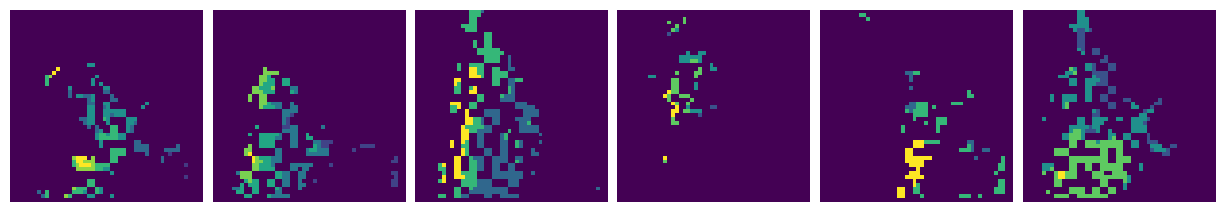

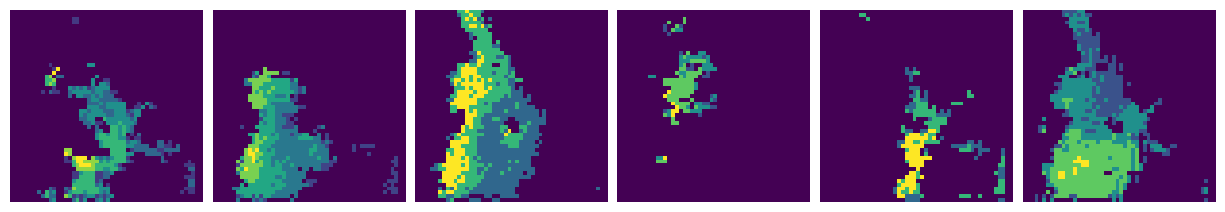

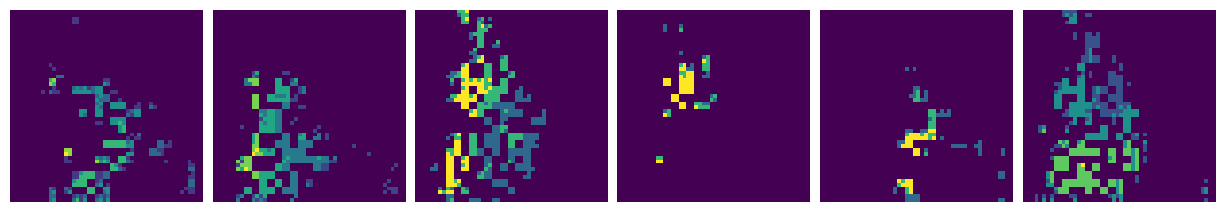

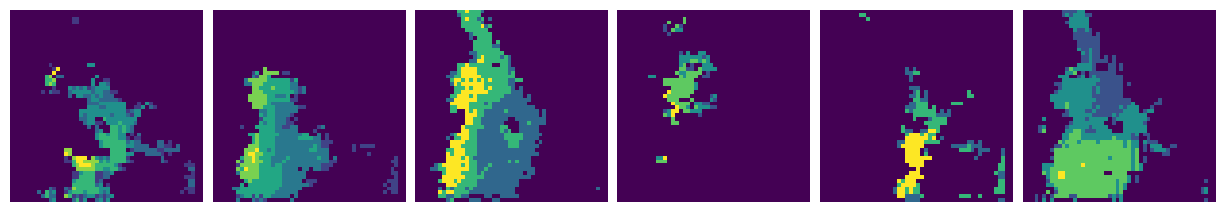

In [23]:
from einops import rearrange
patch_size=(config.patch_size,config.patch_size)
orig_frames = input_tensor.permute(0,1,3,4,2).cpu()
img_squeeze = rearrange(
    orig_frames.numpy(), 
    'b (t p0) (h p1) (w p2) c -> b (t h w) (p0 p1 p2) c', 
    p0=config.tubelet_size, p1=patch_size[0], p2=patch_size[1]
)
img_mean = np.mean(img_squeeze, axis=-2, keepdims=True)
img_variance = np.var(img_squeeze, axis=-2, ddof=1, keepdims=True)
img_norm = (img_squeeze - img_mean) / (np.sqrt(img_variance) + 1e-6)
img_patch = rearrange(img_norm, 'b n p c -> b n (p c)')
img_patch[bool_masked_pos.cpu()] = reconstructed_patches.cpu().detach().numpy()
rec_img = rearrange(img_patch, 'b n (p c) -> b n p c', c=config.num_channels)
# Notice: To visualize the reconstruction video, 
# we add the predict and the original mean and var of each patch.
img_mean = np.mean(img_squeeze, axis=-2, keepdims=True)
img_std = np.sqrt(np.var(img_squeeze, axis=-2, ddof=1, keepdims=True) + 1e-6) 
rec_img = rec_img * img_std + img_mean
rec_img = rearrange(
    rec_img, 
    'b (t h w) (p0 p1 p2) c -> b (t p0) (h p1) (w p2) c', 
    p0=config.tubelet_size, p1=patch_size[0], p2=patch_size[1], h=config.image_size//config.patch_size, w=config.image_size//config.patch_size
)
print(rec_img.shape)
reconstructed_video=rec_img

mask=np.ones_like(img_patch)
mask[bool_masked_pos.cpu()]=0
mask=rearrange(mask,'b n (p c)->b n p c',c=config.num_channels)
mask=rearrange(
    mask,
    'b (t h w) (p0 pl p2) c->b (t p0) (h pl) (w p2) c',
    p0=config.tubelet_size,pl=patch_size[0],p2=patch_size[1],h=config.image_size//config.patch_size, w=config.image_size//config.patch_size)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
IMAGENET_STD=np.array([0.225,0.225,0.225])
IMAGENET_MEAN=np.array([0.45,0.45,0.45])
def show_sequence(seq,sample=8,title='',vmin=0.005, vmax=0.020):

    assert (seq.shape[-1]==config.num_channels)
    fig =plt.figure(figsize=(20,2.5))
    fig.suptitle(title,fontsize=16)
    grid=ImageGrid(fig,111,nrows_ncols=(1,sample),axes_pad=0.1)
    for ax,img in zip(grid,seq):
        # img=img*IMAGENET_STD+IMAGENET_MEAN
        # img=img*100
        ax.imshow((img*255).clip(0,255).astype ('uint8'))
        # ax.imshow(img, cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_axis_off()
    plt.show()
    return

show_sample=6
show_sequence(orig_frames.numpy()[0],sample=show_sample)
# show_sequence(1-mask[0],sample=6)
show_sequence(orig_frames.numpy()[0]*mask[0], sample=show_sample)
show_sequence(rec_img[0],sample=show_sample)
show_sequence(rec_img[0] * (1 - mask[0]), sample=show_sample)
reconstructed_frames = orig_frames.numpy()[0] * mask[0] + rec_img[0] * (1 - mask[0])
show_sequence(reconstructed_frames,sample=show_sample)

# import numpy as np
# difference = reconstructed_frames - orig_frames.numpy()[0]
# squared_difference = np.square(difference)
# mean_squared_difference = np.mean(squared_difference)
# rmse = np.sqrt(mean_squared_difference)
# print(f"RMSE: {rmse}")

In [5]:
import netCDF4 as nc
import numpy as np
import torch
import torch.nn.functional as F

# Function to resize tensor data using PyTorch
def resize_tensor(tensor, size, mode='bilinear', align_corners=False):
    tensor = torch.tensor(tensor, dtype=torch.float32)  # Convert numpy array to tensor
    tensor = tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    resized_tensor = F.interpolate(tensor, size=size, mode=mode, align_corners=align_corners)
    resized_tensor = resized_tensor.squeeze(0).squeeze(0)  # Remove batch and channel dimensions
    return resized_tensor.numpy()

# Path to the existing .nc file that contains the mask, lat, lon, and time
existing_file = 'G:/YuJinYuan-Experiment/MODIS/test/masked/Rrs_412.nc'

# Open the existing .nc file and read the necessary variables
with nc.Dataset(existing_file, 'r') as ds:
    # Print available variables to help identify the mask, lat, lon, and time
    print(ds.variables.keys())
    
    # Read the mask variable (adjust 'mask' to the actual variable name if different)
    mask_var = ds.variables['mask'][:]
    
    # Read the lat, lon, and time variables
    lat_var = ds.variables['lat'][:]
    lon_var = ds.variables['lon'][:]
    time_var = ds.variables['time'][:]  # Assuming 'time' is 1D
    Rrs_var = ds.variables['Rrs_412'][:]
    missing_value = getattr(Rrs_var, '_FillValue', np.nan)  # Use NaN if no _FillValue attribute

    # Safely read the units for each variable
    Rrs_units = ds.variables['Rrs_412'].getncattr('units') if 'units' in ds.variables['Rrs_412'].ncattrs() else 'Unit of Rrs (e.g., sr^-1)'
    mask_units = ds.variables['mask'].getncattr('units') if 'units' in ds.variables['mask'].ncattrs() else 'Mask (binary)'
    lat_units = ds.variables['lat'].getncattr('units') if 'units' in ds.variables['lat'].ncattrs() else 'degrees_north'
    lon_units = ds.variables['lon'].getncattr('units') if 'units' in ds.variables['lon'].ncattrs() else 'degrees_east'
    time_units = ds.variables['time'].getncattr('units') if 'units' in ds.variables['time'].ncattrs() else 'seconds since 1970-01-01 00:00:00 UTC'

    # Optionally print shapes to verify
    print("Original Mask shape:", mask_var.shape)
    print("Original Lat shape:", lat_var.shape)
    print("Original Lon shape:", lon_var.shape)
    print("Time shape:", time_var.shape)

# Resize the mask, lat, and lon to (50, 50)
resized_mask = resize_tensor(mask_var, (50, 50), mode='bilinear', align_corners=False)
resized_lat = resize_tensor(lat_var, (50,), mode='linear', align_corners=False)  # Lat is resized in 1D
resized_lon = resize_tensor(lon_var, (50,), mode='linear', align_corners=False)  # Lon is resized in 1D

# Assuming orig_frames.numpy()[0] and mask[0] are already available with shapes ((24, 50, 50, 1), (24, 50, 50, 1))
Rrs_data = orig_frames.numpy()[0] * mask[0]  # shape (24, 50, 50, 1)
Rrs_data[Rrs_data == 0] = missing_value
# mask_data = (1 - mask[0])  # shape (24, 50, 50, 1)

# Replace your current mask_data with the resized_mask
mask_data = resized_mask  # new shape (50, 50)

# Remove the channel dimension since it's 1, keeping it as (frames, width, height)
Rrs_data = np.squeeze(Rrs_data, axis=-1)  # new shape (24, 50, 50)

# Create a new NetCDF file in NetCDF 3 format
output_file = 'output_data.nc'
with nc.Dataset(output_file, 'w', format='NETCDF3_CLASSIC') as ds:
    # Create dimensions
    time_dim = ds.createDimension('time', len(time_var))  # Keep the original time dimension
    lat_dim = ds.createDimension('lat', resized_lat.shape[0])    # 50
    lon_dim = ds.createDimension('lon', resized_lon.shape[0])    # 50
    
    # Create variables in the specified order: time, Rrs, mask, lon, lat
    time_var_out = ds.createVariable('time', time_var.dtype, ('time',))
    Rrs_var = ds.createVariable('Rrs', np.float32, ('time', 'lat', 'lon'))
    mask_var = ds.createVariable('mask', np.float32, ('lat', 'lon'))
    lon_var_out = ds.createVariable('lon', np.float32, ('lon',))
    lat_var_out = ds.createVariable('lat', np.float32, ('lat',))
    
    # Write data to variables
    time_var_out[:] = time_var  # No resizing needed
    Rrs_var[:] = Rrs_data
    mask_var[:] = mask_data
    lon_var_out[:] = resized_lon
    lat_var_out[:] = resized_lat
    
    # Add attributes by copying from the existing file
    Rrs_var.units = Rrs_units
    mask_var.units = mask_units
    lat_var_out.units = lat_units
    lon_var_out.units = lon_units
    time_var_out.units = time_units

print(f'Data has been successfully written to {output_file}')


dict_keys(['time', 'Rrs_412', 'mask', 'lon', 'lat'])
Original Mask shape: (49, 46)
Original Lat shape: (49,)
Original Lon shape: (46,)
Time shape: (24,)
Data has been successfully written to output_data.nc


dict_keys(['mask', 'lon', 'lat', 'Rrs', 'Rrs_fill', 'time'])
Rrs_fill shape: (24, 50, 50)
RMSE between Rrs_fill and orig_frames1 at 1-mask positions: 0.005968304350972176
RMSE between Rrs_orig and orig_frames1: 0.003548380685970187


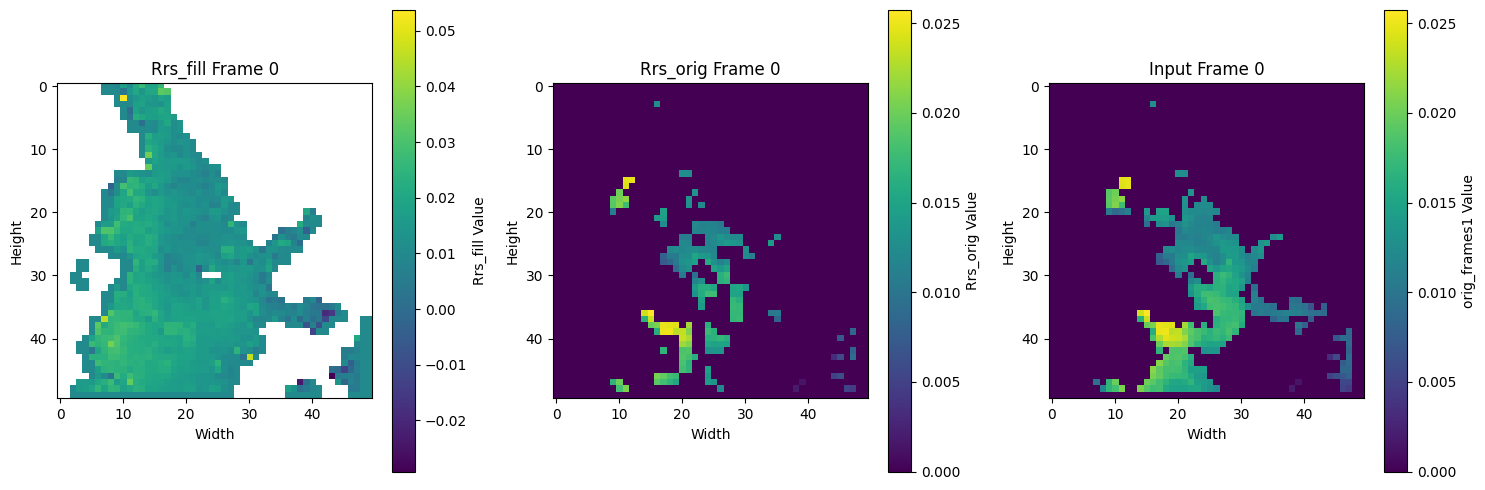

In [14]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# Path to your NetCDF file
file_path = 'E:/ViT2STInterp/dineof_output/output_data_filled.nc'

# Open the NetCDF file
with nc.Dataset(file_path, 'r') as ds:
    # Print available variables to understand the structure
    print(ds.variables.keys())
    
    # Read the Rrs attribute
    Rrs_orig = ds.variables['Rrs'][:]
    Rrs_orig[np.isnan(Rrs_orig)] = 0
    Rrs_orig = np.expand_dims(Rrs_orig, axis=-1)

    Rrs_fill = ds.variables['Rrs_fill'][:]  # Assuming 'Rrs_fill' is the correct name
    Rrs_fill_expanded = np.expand_dims(Rrs_fill, axis=-1)  # Shape becomes (24, 50, 50, 1)
    Rrs_fill_expanded[np.isnan(Rrs_fill_expanded)] = 0

    print("Rrs_fill shape:", Rrs_fill.shape)
    
    # Extract the original frames and mask
    orig_frames1 = orig_frames.numpy()[0]  # Assuming you have already loaded orig_frames
    mask_data1 = 1-mask[0]  # Assuming mask is already loaded

    # Identify the positions where mask is True (i.e., 1 - mask is False)
    missing_positions = mask_data1

    # Calculate RMSE only at the missing positions
    difference = (Rrs_fill_expanded - orig_frames1) * missing_positions
    squared_difference = np.square(difference)
    mean_squared_difference = np.sum(squared_difference) / np.sum(missing_positions)
    rmse = np.sqrt(mean_squared_difference)
    
    # Calculate RMSE between Rrs_orig and orig_frames1
    difference1 = (Rrs_orig - orig_frames1) * (1-missing_positions)
    squared_difference1 = np.square(difference1)
    mean_squared_difference1 = np.sum(squared_difference1) / np.sum(1-missing_positions)
    rmse1 = np.sqrt(mean_squared_difference1)

    # Print the RMSE
    print(f"RMSE between Rrs_fill and orig_frames1 at 1-mask positions: {rmse}")
    print(f"RMSE between Rrs_orig and orig_frames1: {rmse1}")
    
    # Specify the frame number you want to display (0-indexed)
    frame_number = 0  # Replace with the desired frame index

    # Extract the specific frame
    specific_frame_fill = Rrs_fill[frame_number, :, :]
    specific_frame_orig = Rrs_orig[frame_number, :, :, 0]  # Adjust for the expanded dimension
    specific_frame_input = orig_frames1[frame_number, :, :, 0]

    # Display the Rrs_fill frame using matplotlib
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(specific_frame_fill, cmap='viridis')
    plt.colorbar(label='Rrs_fill Value')
    plt.title(f'Rrs_fill Frame {frame_number}')
    plt.xlabel('Width')
    plt.ylabel('Height')

    # Display the Rrs_orig frame using matplotlib
    plt.subplot(1, 3, 2)
    plt.imshow(specific_frame_orig, cmap='viridis')
    plt.colorbar(label='Rrs_orig Value')
    plt.title(f'Rrs_orig Frame {frame_number}')
    plt.xlabel('Width')
    plt.ylabel('Height')

    # Display the orig_frames1 frame using matplotlib
    plt.subplot(1, 3, 3)
    plt.imshow(specific_frame_input, cmap='viridis')
    plt.colorbar(label='orig_frames1 Value')
    plt.title(f'Input Frame {frame_number}')
    plt.xlabel('Width')
    plt.ylabel('Height')

    plt.tight_layout()
    plt.show()


In [11]:
# Calculate the value range for orig_frames1
orig_frames1_min = np.min(orig_frames1)
orig_frames1_max = np.max(orig_frames1)

# Calculate the value range for Rrs_orig
Rrs_orig_min = np.min(Rrs_orig)
Rrs_orig_max = np.max(Rrs_orig)

# Calculate the value range for Rrs_orig
Rrs_fill_min = np.min(Rrs_fill)
Rrs_fill_max = np.max(Rrs_fill)

# Print the value ranges
print(f"orig_frames1 value range: min = {orig_frames1_min}, max = {orig_frames1_max}")
print(f"Rrs_orig value range: min = {Rrs_orig_min}, max = {Rrs_orig_max}")
print(f"Rrs_fill value range: min = {Rrs_fill_min}, max = {Rrs_fill_max}")


orig_frames1 value range: min = -0.004459999036043882, max = 0.02574000135064125
Rrs_orig value range: min = -0.00045399912050925195, max = 0.02574000135064125
Rrs_fill value range: min = -0.02916419506072998, max = 0.05370406433939934


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

IMAGENET_STD = np.array([0.225, 0.225, 0.225])
IMAGENET_MEAN = np.array([0.45, 0.45, 0.45])

def show_sequence(seq_list, sample=8, title='', save_path=None):
    """
    seq_list: List of sequences to show together.
    sample: Number of frames to show per sequence.
    title: Title of the figure.
    save_path: File path to save the image.
    """
    fig = plt.figure(figsize=(20, len(seq_list) * 2.5))
    fig.suptitle(title, fontsize=16)

    grid = ImageGrid(fig, 111, nrows_ncols=(len(seq_list), sample), axes_pad=0.1)

    for i, seq in enumerate(seq_list):
        for ax, img in zip(grid[i*sample:(i+1)*sample], seq):
            # img = img * IMAGENET_STD + IMAGENET_MEAN  # Uncomment for normalization
            ax.imshow((img * 255).clip(0, 255).astype('uint8'))
            ax.set_axis_off()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)

    plt.show()

# Usage example
show_sequence([orig_frames.numpy()[0], orig_frames.numpy()[0] * mask[0], rec_img[0]], 
            sample=5, 
            title='Original, Masked, and Reconstructed Frames',
            save_path='output_image.png')
